In [27]:
# ------------------------------------------------------------------
# 1️⃣ Imports -------------------------------------------------------
# ------------------------------------------------------------------
import warnings                       # <‑‑ para silenciar avisos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from sklearn.impute import SimpleImputer  
import matplotlib.pyplot as plt            
import shap
import kagglehub

# ------------------------------------------------------------------
# 2️⃣ Supressão de warnings ------------------------------------------
# ------------------------------------------------------------------
warnings.filterwarnings("ignore", category=UserWarning)   # ignora TqdmWarning e outros UserWarnings

# ------------------------------------------------------------------
# 3️⃣ Configurações de visualização do Pandas -----------------------
# ------------------------------------------------------------------
pd.set_option('display.max_columns', None)      # mostra todas as colunas
pd.set_option('display.width', 1000)           # largura da tela
pd.set_option('display.max_rows', 500)         # limite superior de linhas

In [28]:
# ------------------------------------------------------------------
# 4️⃣ Leitura do Dataset ---------------------------------------------------
# ------------------------------------------------------------------
dataset_path = kagglehub.dataset_download("mathchi/diabetes-data-set")
df = pd.read_csv(f"{dataset_path}/diabetes.csv", header=None)

print(df.shape)   # (768, 9)

# Nomeie corretamente (8 features + target)
col_names_pt = [
    'Gestações',                     # Pregnancies
    'Glucose',                       # Glucose
    'Pressão_Sistólica',             # BloodPressure
    'Espessura_Pele',                # SkinThickness
    'Insulina',                      # Insulin
    'Índice_Massa_Bíomica',          # BMI
    'Função_Pedigree_Diabetes',      # DiabetesPedigreeFunction
    'Idade',                         # Age
    'Diagnóstico'                    # Outcome (0 = não, 1 = sim)
]
df.columns = col_names_pt

# ------------------------------------------------------------------
# 5️⃣ Tratamento de tipos e correlação -------------------------------
# ------------------------------------------------------------------
print(df.dtypes)

# Se houver colunas do tipo object (string) converte‑as para numéricas
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Matriz de correlação – apenas para inspeção rápida
corr_matrix = df.corr()
print(corr_matrix)


(769, 9)
Gestações                   object
Glucose                     object
Pressão_Sistólica           object
Espessura_Pele              object
Insulina                    object
Índice_Massa_Bíomica        object
Função_Pedigree_Diabetes    object
Idade                       object
Diagnóstico                 object
dtype: object
                          Gestações   Glucose  Pressão_Sistólica  Espessura_Pele  Insulina  Índice_Massa_Bíomica  Função_Pedigree_Diabetes     Idade  Diagnóstico
Gestações                  1.000000  0.129459           0.141282       -0.081672 -0.073535              0.017683                 -0.033523  0.544341     0.221898
Glucose                    0.129459  1.000000           0.152590        0.057328  0.331357              0.221071                  0.137337  0.263514     0.466581
Pressão_Sistólica          0.141282  0.152590           1.000000        0.207371  0.088933              0.281805                  0.041265  0.239528     0.065068
Espessura_Pele

In [29]:
# ------------------------------------------------------------------
# 6️⃣ Tratamento de zeros como valores ausentes --------------------
# ------------------------------------------------------------------
cols_no_zero = ['Glucose', 'Pressão_Sistólica',
                'Espessura_Pele', 'Insulina', 'Índice_Massa_Bíomica']

df[cols_no_zero] = df[cols_no_zero].replace(0, np.nan)

# Imputação com mediana (mais robusta que média para dados tabulares)
imputer = SimpleImputer(strategy='median')

X_raw = df.drop(columns=['Diagnóstico'])
y_raw = df['Diagnóstico']

# ----------------------  ADICIONADO --------------------------------
# Remove linhas onde o alvo está faltando (NaN)
mask_target_ok = ~pd.isna(y_raw)
X_raw   = X_raw.loc[mask_target_ok]
y_raw   = y_raw.loc[mask_target_ok]
# ------------------------------------------------------------------

X_imputed = pd.DataFrame(imputer.fit_transform(X_raw),
                         columns=X_raw.columns)


In [30]:
# ------------------------------------------------------------------
# 7️⃣ Split treino/validação/teste ---------------------------------
# ------------------------------------------------------------------
# 15% de teste, 70% treino e 30% validação (≈ 0.1765 da parte restante)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_imputed, y_raw,
    test_size=0.15,
    stratify=y_raw,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.1765,  # ≈ 30% da parte restante
    stratify=y_train_full,
    random_state=42
)

In [31]:
# ------------------------------------------------------------------
# 8️⃣ Pipeline de pré‑processamento ---------------------------------
# ------------------------------------------------------------------
numeric_features = X_imputed.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[('num', StandardScaler(), numeric_features)]
)

pipe_lr = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
])

pipe_rf = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=250,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    ))
])

In [32]:
# ------------------------------------------------------------------
# 9️⃣ Treinamento ----------------------------------------------------
# ------------------------------------------------------------------
pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
# ------------------------------------------------------------------
# 10️⃣ Avaliação no conjunto de validação -------------------------
# ------------------------------------------------------------------
def evaluate(pipe, X_val, y_val):
    """Retorna métricas e exibe classification_report."""
    y_pred = pipe.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1  = f1_score(y_val, y_pred)
    print(classification_report(y_val, y_pred))
    return {'acurácia': acc, 'recall': rec, 'f1': f1}

print("\n=== Regreção Logística ===")
metrics_lr = evaluate(pipe_lr, X_val, y_val)

print("\n=== Random Forest ===")
metrics_rf = evaluate(pipe_rf, X_val, y_val)


=== Regreção Logística ===
              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83        75
         1.0       0.71      0.61      0.66        41

    accuracy                           0.78       116
   macro avg       0.76      0.74      0.75       116
weighted avg       0.77      0.78      0.77       116


=== Random Forest ===
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82        75
         1.0       0.67      0.63      0.65        41

    accuracy                           0.76       116
   macro avg       0.74      0.73      0.73       116
weighted avg       0.76      0.76      0.76       116




Gráfico SHAP salvo como 'shap_summary.png'.


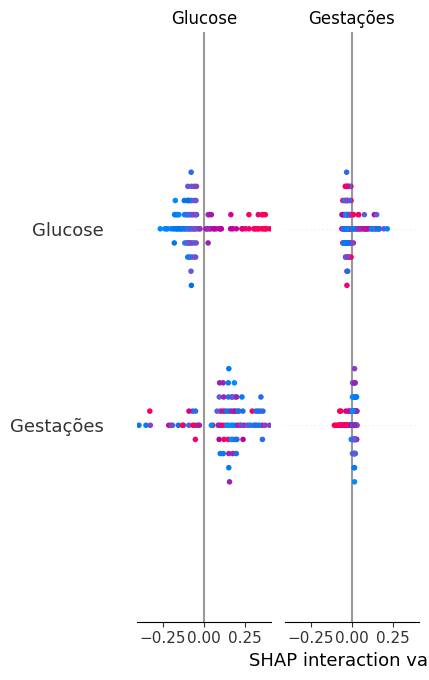

In [36]:
# ------------------------------------------------------------------
# 11️⃣ Interpretação: Feature importance + SHAP --------------------
# ------------------------------------------------------------------

import shap          # <-- certifique‑se que a biblioteca está importada

# 1️⃣ Transformação das features (mesma que o RF recebeu)
X_val_scaled = pipe_rf.named_steps['prep'].transform(X_val)

# 2️⃣ Calcular SHAPs para todas as classes
explainer_rf = shap.TreeExplainer(pipe_rf.named_steps['clf'])
shap_vals    = explainer_rf.shap_values(X_val_scaled)   # shape: (n_samples, n_features)

# Se quiser apenas a classe “1” (ex.: 1 = positivo), faça:
# shap_vals_class_1 = shap_vals[1]        # ← apenas para ilustrar

# 3️⃣ Plot summary
shap.summary_plot(
    shap_vals,                 # <-- use todo o array, não [1]
    X_val_scaled,
    feature_names=numeric_features,
    show=False                # evita exibição automática fora de Jupyter
)

plt.savefig('shap_summary.png')
print("\nGráfico SHAP salvo como 'shap_summary.png'.")

In [38]:
# ------------------------------------------------------------------
# 12️⃣ GridSearchCV para otimizar hiper‑parâmetros -----------------
# ------------------------------------------------------------------

from sklearn.model_selection import StratifiedKFold   # <-- adicione isso

param_grid = {
    'clf__n_estimators': [200, 300, 400],
    'clf__max_depth': [None, 5, 10]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1
)

# Ajustamos no conjunto completo de treino (train + val) para aproveitar mais dados
grid_rf.fit(X_train_full, y_train_full)

print("\nMelhor RF (GridSearch):", grid_rf.best_params_)
print("Score F1 na validação:", grid_rf.best_score_)



Melhor RF (GridSearch): {'clf__max_depth': None, 'clf__n_estimators': 200}
Score F1 na validação: 0.6165922979051305


In [39]:
# ------------------------------------------------------------------
# 13️⃣ Teste final no conjunto de teste ----------------------------
# ------------------------------------------------------------------
y_test_pred = grid_rf.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1  = f1_score(y_test, y_test_pred)

print("\n=== Resultado Final (Test Set) ===")
print(f"Acurácia: {test_acc:.4f}")
print(f"Recall   : {test_rec:.4f}")
print(f"F1‑score : {test_f1:.4f}")
print(classification_report(y_test, y_test_pred))


=== Resultado Final (Test Set) ===
Acurácia: 0.7759
Recall   : 0.6250
F1‑score : 0.6579
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83        76
         1.0       0.69      0.62      0.66        40

    accuracy                           0.78       116
   macro avg       0.75      0.74      0.75       116
weighted avg       0.77      0.78      0.77       116

